In [192]:
import pandas as pd 
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [193]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [194]:
from read_wandb import wandb_results
api = wandb_results("NLP2024_PROJECT_207897091_322720103", wandb_username="noa-levi")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [195]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric) 

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path"]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
    
    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[list(numeric_cols) + [col for col in HPT_cols if col not in numeric_cols]]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])

    mean_df = grouped.mean()
    std_df = grouped.std()
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)

    summary_df['CI_length'] = summary_df['CI'].apply(lambda x: x[1] - x[0])
    summary_df['Min_Max'] = summary_df['values'].apply(lambda x: (min(x), max(x)))

    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# Validation

In [196]:
sweep_ids = ["emo2h460", "zg8oyx4u"]

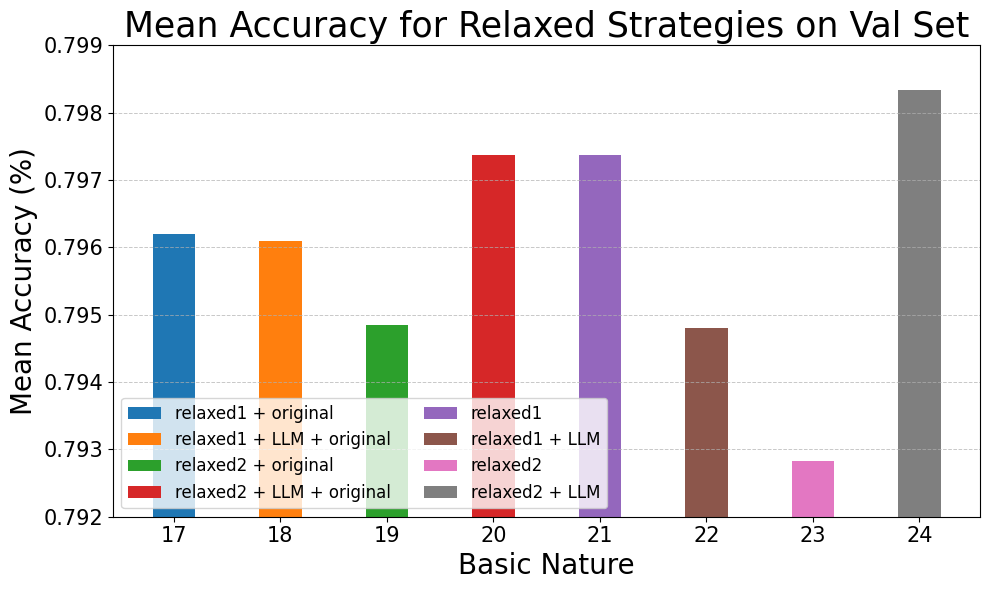

In [197]:

val_set = {
    'mean': [0.796194, 0.796089, 0.794848, 0.797374, 0.797378, 0.794805, 0.792831, 0.798344],
    'inc_simul': [4 for i in range(8)],
    'basic_nature': [17, 18, 19, 20, 21, 22, 23, 24] 
}

val_table = pd.DataFrame(val_set)

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

indices = np.arange(len(val_table['basic_nature'].unique()))
bar_width = 0.4

# Define labels for the legend
labels = [
    "relaxed1 + original",
    "relaxed1 + LLM + original",
    "relaxed2 + original",
    "relaxed2 + LLM + original",
    "relaxed1",
    "relaxed1 + LLM",
    "relaxed2",
    "relaxed2 + LLM"
]

# Set a fixed figure size
plt.figure(figsize=(10, 6))

# Plot 1: Compare mean results for strategies 17 to 24 in val_table
bars = plt.bar(indices, val_table['mean'], bar_width, color=colors[:len(val_table)])

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Labeling the plot
plt.xlabel('Basic Nature', fontsize=20)
plt.ylabel('Mean Accuracy (%)', fontsize=20)
plt.title('Mean Accuracy for Relaxed Strategies on Val Set', fontsize=25)
plt.xticks(indices, val_table['basic_nature'].unique(), fontsize=15, rotation=0, ha='center')
plt.yticks(fontsize=15)
plt.ylim([0.792, 0.799])

# Add legend with a fixed size
plt.legend(bars, labels, fontsize=12, loc='lower left',ncol=2)
# Show the plot
plt.tight_layout()
plt.show()


## HyperParameterTuning

In [198]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

HPT_results_df = result_metric(sweep_ids, "option", drop_HPT=False, epoch="best")
df_reset = HPT_results_df.copy().reset_index()
filtered_df = df_reset[~df_reset['config_basic_nature'].isin([25, 26, 27])]
filtered_df = filtered_df[filtered_df['config_features'].isin(['EFs'])]

filtered_df = filtered_df[filtered_df['config_online_simulation_factor'] != 0]
filtered_df.sort_values(by='mean', ignore_index=True, ascending=False)
filtered_df


Total number of sweeps: 2
Download sweep_id='emo2h460' data...


Download sweep_id='zg8oyx4u' data...
['config_seed', 'config_features', 'config_input_dim', 'config_REVIEW_DIM', 'config_basic_nature', 'config_FEATURES_PATH', 'config_online_simulation_factor']


,config_features,config_input_dim,config_REVIEW_DIM,config_basic_nature,config_FEATURES_PATH,config_online_simulation_factor,mean,std,values,epoch,CI,CI_length,Min_Max
3,EFs,60,37,12,data/EFs_by_GPT35.csv,4,0.796385,0.008465,"[0.7955529895975343, 0.7910979497642225, 0.807...",12,"(0.7899990762158853, 0.803103075434897)",0.013104,"(0.7861232459767236, 0.8076184048105846)"
5,EFs,60,37,17,data/EFs_by_GPT35.csv,4,0.795993,0.012496,"[0.8004488658193148, 0.7910049316881792, 0.813...",9,"(0.7859292188919635, 0.8063330659078032)",0.020404,"(0.7793974323174412, 0.8134374020428299)"
7,EFs,60,37,18,data/EFs_by_GPT35.csv,4,0.796089,0.012990,"[0.8030776889613664, 0.7842413216572973, 0.812...",7,"(0.7857330510184584, 0.8060053403124448)",0.020272,"(0.7813968915327314, 0.8121422701810458)"
9,EFs,60,37,19,data/EFs_by_GPT35.csv,4,0.794848,0.003705,"[0.7982036627297778, 0.7887782426621658, 0.795...",8,"(0.7918592591235771, 0.7974402875689872)",0.005581,"(0.7887782426621658, 0.7982036627297778)"
11,EFs,60,37,20,data/EFs_by_GPT35.csv,4,0.797374,0.009449,"[0.8003521474502342, 0.7867783567635749, 0.810...",9,"(0.7901441058125563, 0.8045231128448862)",0.014379,"(0.7867783567635749, 0.8107795609368641)"
13,EFs,60,37,21,data/EFs_by_GPT35.csv,4,0.797378,0.011228,"[0.8062198400532707, 0.7799454924675318, 0.806...",8,"(0.7882573785735971, 0.8044735225006212)",0.016216,"(0.7799454924675318, 0.806972399012572)"
15,EFs,60,37,22,data/EFs_by_GPT35.csv,4,0.794805,0.004497,"[0.7918882783967689, 0.7916566859055123, 0.802...",13,"(0.7920433411498211, 0.7988134654826886)",0.006770,"(0.7916566859055123, 0.8025290274890415)"
17,EFs,60,37,23,data/EFs_by_GPT35.csv,4,0.792831,0.011781,"[0.795919630586218, 0.7781349660587329, 0.8099...",9,"(0.7846313327245523, 0.8033429118447234)",0.018712,"(0.7781349660587329, 0.8099057188785582)"
19,EFs,60,37,24,data/EFs_by_GPT35.csv,4,0.798344,0.011427,"[0.8105724201616443, 0.7851809511790032, 0.810...",16,"(0.7896368426560618, 0.80696208307902)",0.017325,"(0.7851809511790032, 0.8105724201616443)"


In [199]:
df = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC) 

config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
config_cols_no_seeds = [c for c in config_cols if c!="config_seed"]
HPT_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path"]
HPT_cols_no_seeds = [c for c in HPT_cols if c!="config_seed"]
epoch_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot_epoch" in col]

melted_df = df.melt(id_vars=HPT_cols, value_vars=epoch_columns, var_name='epoch', value_name='accuracy')
melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)

Total number of sweeps: 2
Download sweep_id='emo2h460' data...
Download sweep_id='zg8oyx4u' data...


In [200]:
df_copy = melted_df.copy()
df_agg = melted_df.groupby(HPT_cols_no_seeds + ['epoch']).accuracy.agg(['mean', 'std']).reset_index()
df_filter = df_agg[~df_agg['config_basic_nature'].isin([25, 26, 27])]
df_filter = df_filter[df_filter['config_features'].isin(['EFs'])]
df_filter = df_filter[df_filter['config_online_simulation_factor'] != 0]
df_filter['mean'] *= 100

Total number of sweeps: 2
Download sweep_id='emo2h460' data...
Download sweep_id='zg8oyx4u' data...


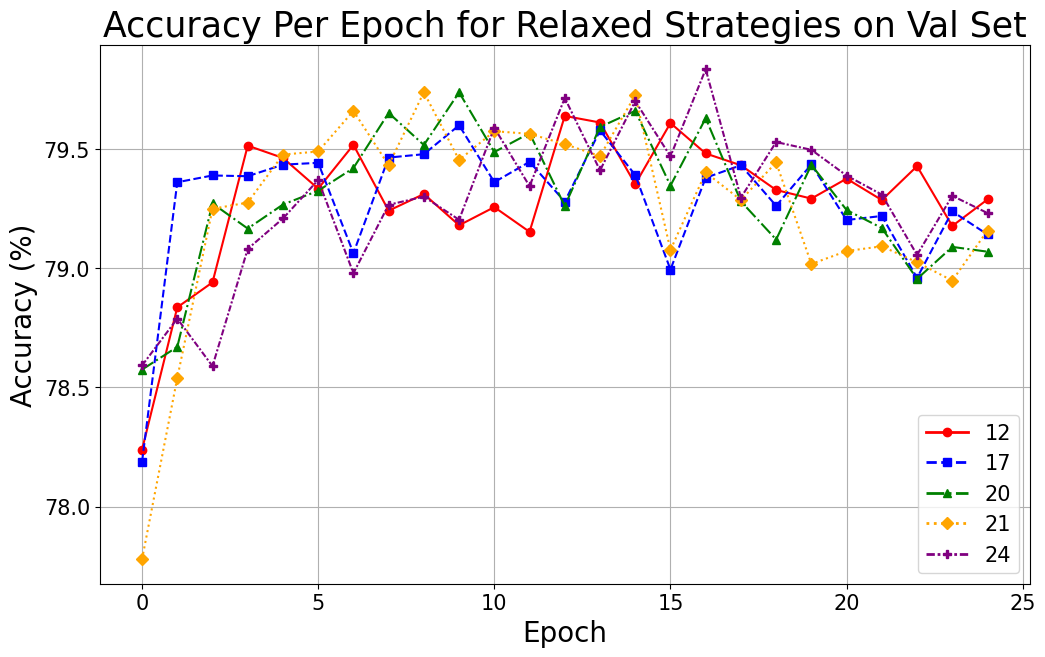

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming df is already created and filtered
df = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC)
df = df[df['config_features'] == 'EFs']
df = df[df['config_online_simulation_factor'] == 4]

config_cols = [c for c in df.columns if "config_" in c and c != "config_wandb_run_id" and c != "config_online_simulation_size"]
param_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path" and col != "config_seed"]
epoch_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot_epoch" in col]

melted_df = df.melt(id_vars=param_cols + ["config_seed"], value_vars=epoch_columns, var_name='epoch', value_name='accuracy')
melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)

df_agg = melted_df.groupby(param_cols + ['epoch']).accuracy.agg(['mean', 'std']).reset_index()
df_agg['mean'] *= 100
df_agg = df_agg[df_agg['config_basic_nature'].isin([12, 17, 20 ,21, 24])]

colors = ['red', 'blue', 'green', 'orange', 'purple']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))  ]
markers = ['o', 's', '^', 'D', 'P']
labels = [12, 17, 20 ,21, 24]

# Plot each hyperparameter combination
unique_combinations = df_agg[param_cols].drop_duplicates()
plt.figure(figsize=(12, 7))

color_map = {idx: colors[i % len(colors)] for i, idx in enumerate(unique_combinations.index)}
linestyle_map = {idx: linestyles[i % len(linestyles)] for i, idx in enumerate(unique_combinations.index)}
marker_map = {idx: markers[i % len(markers)] for i, idx in enumerate(unique_combinations.index)}

for idx, combination in unique_combinations.iterrows():
    combination_mask = np.all([df_agg[col] == combination[col] for col in param_cols], axis=0)
    group = df_agg[combination_mask]
    plt.plot(group['epoch'], group['mean'], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], label=f"Combination {idx}")

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.title('Accuracy Per Epoch for Relaxed Strategies on Val Set', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Create legend handles
handles = [Line2D([0], [0], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], lw=2) for idx in unique_combinations.index]
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=15)

plt.grid(True)
plt.show()


# Test:

In [202]:
sweep_ids = ["qbhbd4fu", "r5hl9zym", "yhgy96oe", "nmiv2gwu","5b4snpv8","w4ch5lla"] 

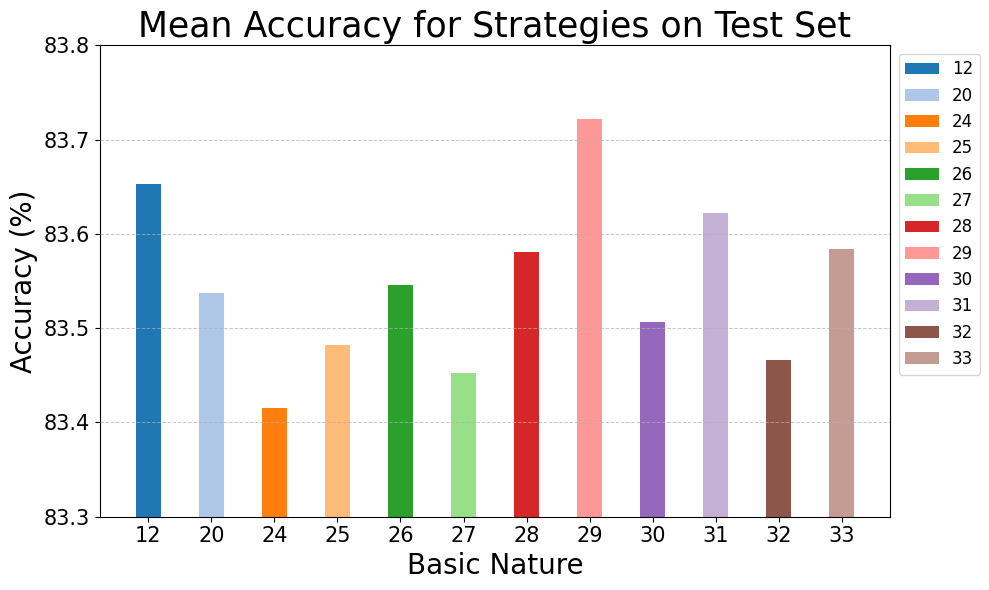

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

val_set = {
    'mean': [83.6534, 83.5368, 83.4151, 83.4822, 83.5456, 83.4523, 83.5808, 83.7215, 83.5068, 83.6224, 83.4661, 83.5844] ,
    'inc_simul': [4 for i in range(12)],
    'basic_nature': [12, 20, 24, 25, 26, 27,28, 29, 30, 31, 32, 33] 
}

val_table = pd.DataFrame(val_set)

# Get a custom color palette
colors = plt.get_cmap('tab20').colors

indices = np.arange(len(val_table['basic_nature'].unique()))
bar_width = 0.4

# Define labels for the legend
labels = [12, 20, 24, 25, 26, 27,28, 29, 30, 31, 32, 33]
# Set a fixed figure size
plt.figure(figsize=(10, 6))

# Plot 1: Compare mean results for strategies basic_nature
bars = plt.bar(indices, val_table['mean'], bar_width, color=colors[:len(indices)])

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Labeling the plot
plt.xlabel('Basic Nature', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.title('Mean Accuracy for Strategies on Test Set', fontsize=25)
plt.xticks(indices, val_table['basic_nature'].unique(), fontsize=15, rotation=0, ha='center')
plt.yticks(fontsize=15)
plt.ylim([83.3, 83.8])

# Add legend with a fixed size
plt.legend(bars, labels, fontsize=12, bbox_to_anchor=(1.00, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [204]:
# Perform filtering on the original DataFrame
sweep_ids = ["qbhbd4fu", "r5hl9zym", "yhgy96oe","5b4snpv8" ,"5b4snpv8","w4ch5lla","z1eua95h"] 
test_results_df = result_metric(sweep_ids, "basic_nature", drop_HPT=False, epoch="best")
test_results_df


Total number of sweeps: 7
Download sweep_id='qbhbd4fu' data...


Download sweep_id='r5hl9zym' data...
Download sweep_id='yhgy96oe' data...
Download sweep_id='5b4snpv8' data...
Download sweep_id='5b4snpv8' data...
Download sweep_id='w4ch5lla' data...
Download sweep_id='z1eua95h' data...
['config_seed', 'config_features', 'config_input_dim', 'config_REVIEW_DIM', 'config_basic_nature', 'config_FEATURES_PATH', 'config_online_simulation_factor']


/tmp/ipykernel_3146256/150169320.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mean_df[col] = df[col]
/tmp/ipykernel_3146256/150169320.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mean_df[col] = df[col]
/tmp/ipykernel_3146256/150169320.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

mean  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor             
BERT            59.0             36.0              12                  data/BERT_PCA_36.csv  0                                0.826854   
                                                                                             4                                0.830790   
EFs             60.0             37.0              12                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.836534   
                                                   20                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.835368   
                                                   21                  data/EFs_by_GPT35.csv 4                                0.833078   
                                                   24                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.834151   
                                                   25                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.834822   
                                                   26                  data/EFs_by_GPT35.csv 4                                0.835456   
                                                   27                  data/EFs_by_GPT35.csv 4                                0.834523   
                                                   28                  data/EFs_by_GPT35.csv 4                                0.835808   
                                                   29                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.837150   
                                                   30                  data/EFs_by_GPT35.csv 4                                0.834124   
                                                   31                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.835068   
                                                   32                  data/EFs_by_GPT35.csv 0                                0.828898   
                                                                                             4                                0.836224   
                                                   33                  data/EFs_by_GPT35.csv 4                                0.834661   
                                                   34                  data/EFs_by_GPT35.csv 4                                0.835844   
GPT4            59.0             36.0              12                  data/GPT4_PCA_36.csv  0                                0.833291   
                                                                                             4                                0.832273   

                                                                                                                                   std  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor             
BERT            59.0             36.0              12                  data/BERT_PCA_36.csv  0                                0

In [205]:
print(test_results_df.columns)


Index(['mean', 'std', 'values', 'epoch', 'CI', 'CI_length', 'Min_Max'], dtype='object')


In [206]:

selected_columns = ['mean', 'std', 'CI']
test_results_df_display = test_results_df[selected_columns]

test_results_df_display.to_csv('sweeps_csvs/test_results.csv')

In [207]:
filtered_df = test_results_df[(test_results_df['mean'] >  0.8358)]

filtered_df

mean  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor             
EFs             60.0             37.0              12                  data/EFs_by_GPT35.csv 4                                0.836534   
                                                   28                  data/EFs_by_GPT35.csv 4                                0.835808   
                                                   29                  data/EFs_by_GPT35.csv 4                                0.837150   
                                                   32                  data/EFs_by_GPT35.csv 4                                0.836224   
                                                   34                  data/EFs_by_GPT35.csv 4                                0.835844   

                                                                                                                                   std  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor             
EFs             60.0             37.0              12                  data/EFs_by_GPT35.csv 4                                0.002128   
                                                   28                  data/EFs_by_GPT35.csv 4                                0.004232   
                                                   29                  data/EFs_by_GPT35.csv 4                                0.000927   
                                                   32                  data/EFs_by_GPT35.csv 4                                0.002437   
                                                   34                  data/EFs_by_GPT35.csv 4                                0.001020   

                                                                                                                                                                         values  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor                                                      
EFs             60.0             37.0              12                  data/EFs_by_GPT35.csv 4                                [0.835740803191593, 0.8377435333486027, 0.8396...   
                                                   28                  data/EFs_by_GPT35.csv 4                                [0.8393403951280203, 0.8301136711676507, 0.839...   
                                                   29                  data/EFs_by_GPT35.csv 4                                [0.837713383542635, 0.8370784606422689, 0.8363...   
                                                   32                  data/EFs_by_GPT35.csv 4                                [nan, 0.8382810084937229, 0.8359336251264214, ...   
                                                   34                  data/EFs_by_GPT35.csv 4                                [0.8353927249580638, 0.8366281573954447, 0.837...   

                                                                                                                              epoch  \
config_features config_input_dim config_REVIEW_DIM config_basic_nature config_FEATURES_PATH  config_online_simulation_factor          
EFs             60.0             37.0              12                  data/EFs_by_GPT35.csv 4                                   13   
                                                   28                  data/EFs_by_GPT35.csv 4                                   23   
                                                   29                  data/EFs_by_GPT35.csv 4                                   14   
                                                   32                  data/EFs_by_GPT35.csv 4                                   19   
                                                   34                  data/EFs_by_GPT35.csv 4                                    7 

Total number of sweeps: 7
Download sweep_id='qbhbd4fu' data...
Download sweep_id='r5hl9zym' data...
Download sweep_id='yhgy96oe' data...
Download sweep_id='5b4snpv8' data...
Download sweep_id='5b4snpv8' data...
Download sweep_id='w4ch5lla' data...


Download sweep_id='z1eua95h' data...


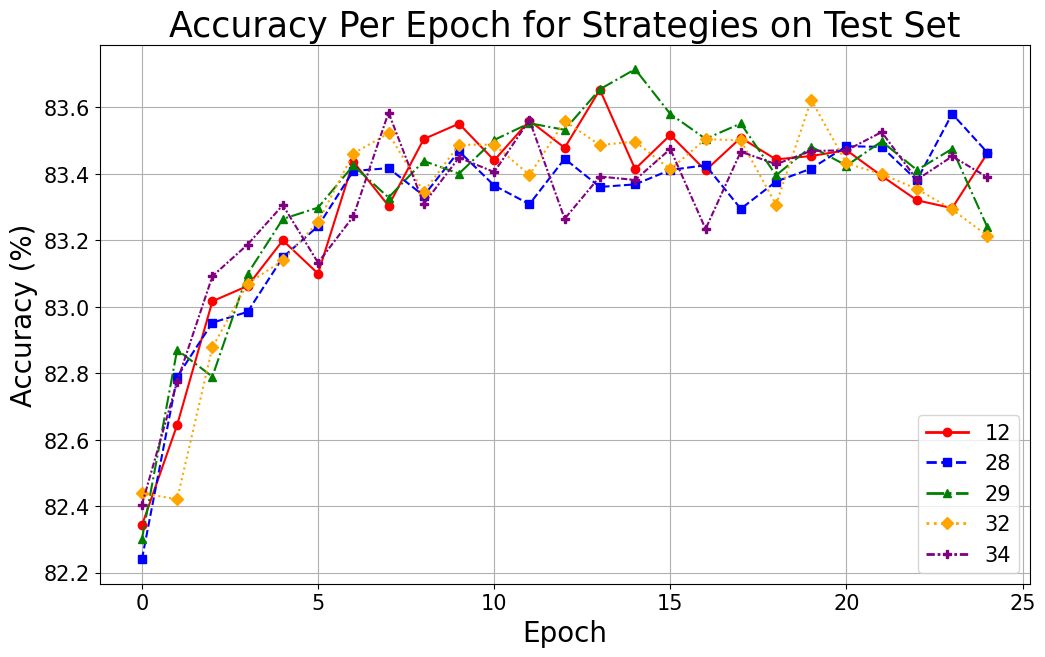

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming df is already created and filtered
df = api.get_sweeps_results(sweep_ids, metric=BASE_METRIC)
df = df[df['config_features'] == 'EFs']
df = df[df['config_online_simulation_factor'] == 4]

config_cols = [c for c in df.columns if "config_" in c and c != "config_wandb_run_id" and c != "config_online_simulation_size"]
param_cols = [col for col in config_cols if df[col].nunique() > 1 and col != "config_expert_reliability_path" and col != "config_seed"]
epoch_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot_epoch" in col]

melted_df = df.melt(id_vars=param_cols + ["config_seed"], value_vars=epoch_columns, var_name='epoch', value_name='accuracy')
melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)

df_agg = melted_df.groupby(param_cols + ['epoch']).accuracy.agg(['mean', 'std']).reset_index()
df_agg['mean'] *= 100
df_agg = df_agg[df_agg['config_basic_nature'].isin([12, 28, 29, 32, 34])]

colors = ['red', 'blue', 'green', 'orange', 'purple']
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'P']
labels = [12, 28, 29, 32, 34]

# Plot each hyperparameter combination
unique_combinations = df_agg[param_cols].drop_duplicates()
plt.figure(figsize=(12, 7))

color_map = {idx: colors[i % len(colors)] for i, idx in enumerate(unique_combinations.index)}
linestyle_map = {idx: linestyles[i % len(linestyles)] for i, idx in enumerate(unique_combinations.index)}
marker_map = {idx: markers[i % len(markers)] for i, idx in enumerate(unique_combinations.index)}

for idx, combination in unique_combinations.iterrows():
    combination_mask = np.all([df_agg[col] == combination[col] for col in param_cols], axis=0)
    group = df_agg[combination_mask]
    plt.plot(group['epoch'], group['mean'], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], label=f"Combination {idx}")

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.title('Accuracy Per Epoch for Strategies on Test Set', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Create legend handles
handles = [Line2D([0], [0], color=color_map[idx], linestyle=linestyle_map[idx], marker=marker_map[idx], lw=2) for idx in unique_combinations.index]
plt.legend(handles=handles, labels=labels, loc='lower right', fontsize=15)

plt.grid(True)
plt.show()
